## Ships Detection in Satellite Imagery
## Preprocessing steps

<img src="planet_logo.png" alt="planet_logo" style="float: left; width: 250px;"/>     

Planet Labs Open California Dataset <br>
https://www.planet.com/products/open-california/ <br>
California Satellite image from October 2013 <br>
Made available under CC-BY-SA license at a 2 weeks delay from image acquisition <br>

Dataset obtain from Kaggle Competition, https://www.kaggle.com/rhammell/ships-in-satellite-imagery <br>


Locations of satellite image used TBC -- write geo lat long

EDA, taking a look at the dataset.<br>
initial deep learning model building <br>
Short Note: Image dataset was updated. 700 ship images and 2100 non ship images <br>

In [1]:
## standard library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import random

## sklearn
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## json
import json

## image processing library
import cv2
from skimage import data, io, filters
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa

## Keras + Tensorflow
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import tensorflow as tf

## tflearn
import tflearn

%matplotlib inline

Using TensorFlow backend.


### Some EDA on Json file
Actual image data by pixel is already included in the json file

In [2]:
f = open(r'./ships-in-satellite-imagery/shipsnet_v2.json')
dataset = json.load(f)
f.close()

labels = np.array(dataset['labels']).astype('uint8')

In [3]:
df= pd.DataFrame(dataset)
df.head()

,data,labels,locations,scene_ids
0,"[41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...",1,"[-122.34270462076896, 37.75058641760489]",20170501_180618_1005
1,"[22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...",1,"[-122.34975593269652, 37.76979644106731]",20170501_181320_0e1f
2,"[112, 112, 106, 104, 107, 109, 113, 115, 108, ...",1,"[-122.34908354683306, 37.74935096766827]",20170609_180756_103a
3,"[72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...",1,"[-122.32613080820607, 37.73816285249999]",20170721_180825_100b
4,"[63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...",1,"[-122.3332290637038, 37.721168346437786]",20170702_180943_103c


Dataset is a dictionary which contains data image pixels values in a list of len 19200. First 6400 is R values, Next 6400 is G and final 6400 is B. 

Within R values, the first 80 values represent the first row, then second 80 values represent the second row and so on. 
To form an image, the data is arrange in numpy array of dimension 80 X 80 X 3.

In [4]:
print(type(dataset))
print(dataset.keys())

<class 'dict'>
dict_keys(['locations', 'scene_ids', 'data', 'labels'])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
data         2800 non-null object
labels       2800 non-null int64
locations    2800 non-null object
scene_ids    2800 non-null object
dtypes: int64(1), object(3)
memory usage: 87.6+ KB


In [6]:
df.shape

(2800, 4)

In [7]:
### data type ['data'] for each image is a list of int
print(type(df.data[0]))
print(type(df.data[0][0]))

<class 'list'>
<class 'int'>


In [8]:
### data type ['labels'] for each image is int64 -> convert to int8

df['labels'] = np.array(df['labels']).astype('uint8')
print(type(df['labels'][0]))

<class 'numpy.uint8'>


In [9]:
### data type ['locations'] for each image is a list of float for lat and long
print(type(df.locations[0][0]))
print(type(df.locations[0][1]))

## Extracting Lat Long information
df['longtitude'] = df.locations.map(lambda x: x[0])
df['latitude'] = df.locations.map(lambda x: x[1])

df.head()

<class 'float'>
<class 'float'>


,data,labels,locations,scene_ids,longtitude,latitude
0,"[41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...",1,"[-122.34270462076896, 37.75058641760489]",20170501_180618_1005,-122.342705,37.750586
1,"[22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...",1,"[-122.34975593269652, 37.76979644106731]",20170501_181320_0e1f,-122.349756,37.769796
2,"[112, 112, 106, 104, 107, 109, 113, 115, 108, ...",1,"[-122.34908354683306, 37.74935096766827]",20170609_180756_103a,-122.349084,37.749351
3,"[72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...",1,"[-122.32613080820607, 37.73816285249999]",20170721_180825_100b,-122.326131,37.738163
4,"[63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...",1,"[-122.3332290637038, 37.721168346437786]",20170702_180943_103c,-122.333229,37.721168


In [10]:
### data type ['scene_ids'] for each image is a string
print(type(df.scene_ids[0]))

### Example scene ids: 20170501_180618_1005
### 20170501 --- date of image
### 180618 --- time of image (in UTC)
### 1005 --- sat_id

# Extract these date, time and sat_id out
df['date']=df.scene_ids.map(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8])
df['time_UTC']=df.scene_ids.map(lambda x: x[9:11] + ':' + x[11:13] + ':' + x[13:15])
df['sat_id']=df.scene_ids.map(lambda x: x[16:20])

df.head()

<class 'str'>


,data,labels,locations,scene_ids,longtitude,latitude,date,time_UTC,sat_id
0,"[41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...",1,"[-122.34270462076896, 37.75058641760489]",20170501_180618_1005,-122.342705,37.750586,2017-05-01,18:06:18,1005
1,"[22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...",1,"[-122.34975593269652, 37.76979644106731]",20170501_181320_0e1f,-122.349756,37.769796,2017-05-01,18:13:20,0e1f
2,"[112, 112, 106, 104, 107, 109, 113, 115, 108, ...",1,"[-122.34908354683306, 37.74935096766827]",20170609_180756_103a,-122.349084,37.749351,2017-06-09,18:07:56,103a
3,"[72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...",1,"[-122.32613080820607, 37.73816285249999]",20170721_180825_100b,-122.326131,37.738163,2017-07-21,18:08:25,100b
4,"[63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...",1,"[-122.3332290637038, 37.721168346437786]",20170702_180943_103c,-122.333229,37.721168,2017-07-02,18:09:43,103c


In [11]:
## Extracting R,G,B

R = []
G = []
B = []

for i, v in enumerate(df.data):
    R.append(v[0:6400])
    G.append(v[6400:12800])
    B.append(v[12800:19200])

df['R'] = R
df['G'] = G
df['B'] = B

In [12]:
print (len(df.R[0]))
print (len(df.B[0]))
print (len(df.G[0]))

6400
6400
6400


In [13]:
df.head()

,data,labels,locations,scene_ids,longtitude,latitude,date,time_UTC,sat_id,R,G,B
0,"[41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...",1,"[-122.34270462076896, 37.75058641760489]",20170501_180618_1005,-122.342705,37.750586,2017-05-01,18:06:18,1005,"[41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...","[49, 47, 48, 50, 51, 51, 50, 49, 52, 49, 41, 4...","[36, 35, 35, 37, 36, 36, 35, 35, 38, 36, 28, 3..."
1,"[22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...",1,"[-122.34975593269652, 37.76979644106731]",20170501_181320_0e1f,-122.349756,37.769796,2017-05-01,18:13:20,0e1f,"[22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...","[41, 39, 45, 44, 38, 33, 39, 36, 36, 45, 37, 3...","[43, 41, 47, 46, 39, 35, 44, 39, 38, 49, 39, 3..."
2,"[112, 112, 106, 104, 107, 109, 113, 115, 108, ...",1,"[-122.34908354683306, 37.74935096766827]",20170609_180756_103a,-122.349084,37.749351,2017-06-09,18:07:56,103a,"[112, 112, 106, 104, 107, 109, 113, 115, 108, ...","[113, 112, 106, 105, 107, 108, 111, 112, 106, ...","[91, 90, 85, 83, 86, 87, 90, 91, 87, 101, 100,..."
3,"[72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...",1,"[-122.32613080820607, 37.73816285249999]",20170721_180825_100b,-122.326131,37.738163,2017-07-21,18:08:25,100b,"[72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...","[82, 84, 84, 83, 84, 84, 85, 84, 84, 85, 84, 8...","[66, 69, 67, 63, 63, 64, 66, 64, 63, 63, 62, 6..."
4,"[63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...",1,"[-122.3332290637038, 37.721168346437786]",20170702_180943_103c,-122.333229,37.721168,2017-07-02,18:09:43,103c,"[63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...","[73, 69, 68, 72, 76, 77, 79, 72, 63, 73, 79, 7...","[58, 57, 55, 58, 61, 63, 65, 59, 51, 58, 61, 5..."


In [14]:
### number of unique satellite image
df.scene_ids.nunique()

284

In [31]:
bb = df.scene_ids.value_counts()
bb.to_csv('./preprocessing/scene_ids.csv')
print (type(bb))

<class 'pandas.core.series.Series'>


In [16]:
## Export CSV for scene_ids
import csv

df.to_csv('./preprocessing/scene_ids.csv')

In [17]:
## Calculate the mean and range of R, G and B in each image, do some normalization

In [18]:
r_mean = []
r_std = []
r_range = []

for i,v in enumerate(df.R):
    r_mean.append(np.mean(v))
    r_std.append(np.std(v))
    r_range.append(max(v)-min(v))

df['r_mean'] = r_mean
df['r_std'] = r_std
df['r_range'] = r_range

In [19]:
b_mean = []
b_std = []
b_range = []

for i,v in enumerate(df.B):
    b_mean.append(np.mean(v))
    b_std.append(np.std(v))
    b_range.append(max(v)-min(v))

df['b_mean'] = b_mean
df['b_std'] = b_std
df['b_range'] = b_range

In [20]:
g_mean = []
g_std = []
g_range = []

for i,v in enumerate(df.G):
    g_mean.append(np.mean(v))
    g_std.append(np.std(v))
    g_range.append(max(v)-min(v))

df['g_mean'] = g_mean
df['g_std'] = g_std
df['g_range'] = g_range

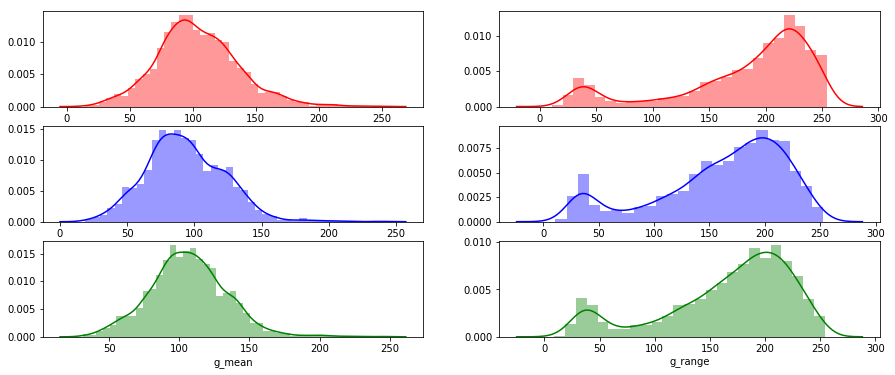

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,6))
sns.distplot(df.r_mean, color = 'r', ax=ax[0,0])
sns.distplot(df.r_range, color = 'r', ax=ax[0,1])
sns.distplot(df.b_mean, color = 'b', ax=ax[1,0])
sns.distplot(df.b_range, color = 'b', ax=ax[1,1])
sns.distplot(df.g_mean, color = 'g', ax=ax[2,0])
sns.distplot(df.g_range, color = 'g', ax=ax[2,1])

In [22]:
df.columns

Index(['data', 'labels', 'locations', 'scene_ids', 'longtitude', 'latitude',
       'date', 'time_UTC', 'sat_id', 'R', 'G', 'B', 'r_mean', 'r_std',
       'r_range', 'b_mean', 'b_std', 'b_range', 'g_mean', 'g_std', 'g_range'],
      dtype='object')

In [23]:
df.data = df.data.map(lambda x: np.array(x).astype('uint8'))

In [24]:
## THE FIRST 80

## RESHAPE -- OUTER AXES FIRST, THEN 80 BY 80. Separate
## TRANSPOSE -- TELL WHICH AXES TO START 

k = df.data[0].reshape(3,80,80).transpose([1,2,0])

k.shape

(80, 80, 3)

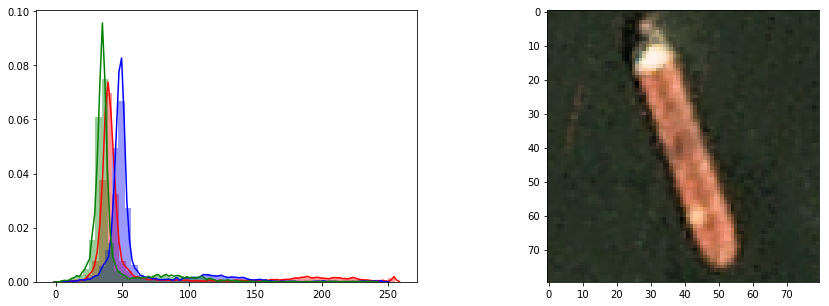

In [25]:
## r,g,b histogram of image[0] --> R,G,B

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.distplot(df.R[0], color = 'r', ax=ax[0])
sns.distplot(df.G[0], color = 'b', ax=ax[0])
sns.distplot(df.B[0], color = 'g', ax=ax[0])

ax[1].imshow(k)


The scene ids can be use with Planet API to download the original satellite image from PLANET LABS Database

In [26]:
max(df.date)

'2017-09-25'

In [27]:
## Length of each image (reshape to 80 X 80 X 3)
len(df.data[0])

19200

In [28]:
## labels, 1 for ships, 0 for non ships
df['labels'].value_counts()

0    2100
1     700
Name: labels, dtype: int64

In [29]:
df.to_pickle('preprocessing/preprocessed_df.pkl')

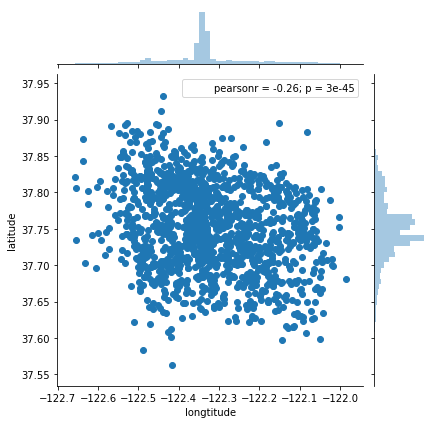

In [30]:
## sampling point on the image

## PLot of Lat long
sns.jointplot(x='longtitude', y ='latitude', data=df)

## Preprocessing of images
Reshape of image to 80 by 80 by 3 matrix using reshape

In [32]:
df.data[0][6399]

35

In [33]:
## image data is a 2800 by 19200 np.array
## easy to process from json dictionary to numpy array
imgdata = np.array(dataset['data']).astype('uint8')



im = imgdata.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])

im.shape

print (im[0,:,:,0])

[[41 40 41 ..., 41 37 36]
 [39 36 37 ..., 35 32 33]
 [38 40 38 ..., 33 38 34]
 ..., 
 [40 43 45 ..., 34 38 39]
 [39 44 47 ..., 32 40 43]
 [40 43 43 ..., 31 36 35]]


In [34]:
imgdata

array([[ 41,  40,  41, ...,  31,  34,  32],
       [ 22,  19,  26, ...,  39,  27,  40],
       [112, 112, 106, ...,  88,  88,  82],
       ..., 
       [ 76,  56,  52, ...,  88,  79,  83],
       [ 64,  61,  61, ...,  42,  43,  43],
       [126, 119, 111, ..., 145, 151, 162]], dtype=uint8)

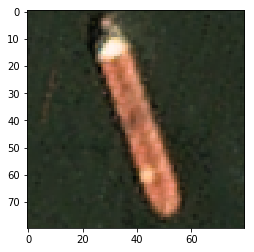

In [35]:
img = Image.fromarray(im[0])
plt.imshow(img)

<class 'PIL.Image.Image'>
AxesSubplot(0.398529,0.125;0.227941x0.755)


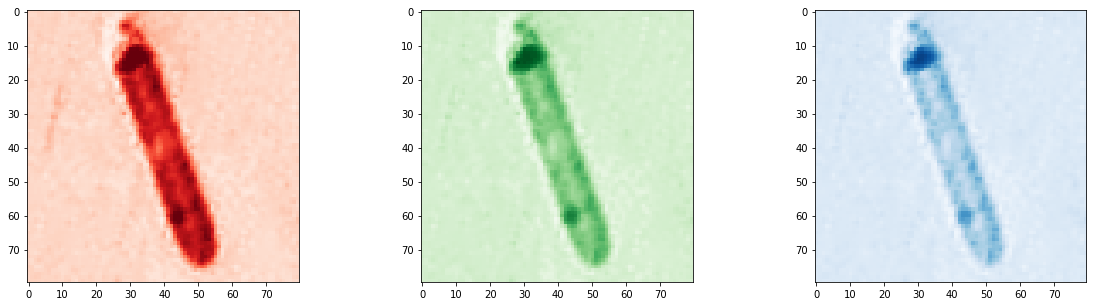

In [36]:
### Plotting RGB

import matplotlib.cm as cm

print(type(img))
r, g, b = img.split()


fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5))
print(axs[1])
axs[0].imshow(im[0,:,:,0], vmin=0, vmax=255, cmap='Reds')
axs[1].imshow(im[0,:,:,1], vmin=0, vmax=255, cmap='Greens')
axs[2].imshow(im[0,:,:,2], vmin=0, vmax=255, cmap='Blues')
